In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down
import matplotlib.pyplot as plt

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [2]:
def extract_sample_data(inputfile, outputfile,
                        clat=34.875, clon=-98.125, npix=3, dx=0.25):
    '''------------------------------------------------------------------------
    Extract a given bounding box centered in (clat, clon) with size npix
    grid cells from an input hdf file
    and save it as nc dataset for further analysis
    ------------------------------------------------------------------------'''
    # f = h5py.File(os.path.join(cdat.tmpa_dir, 'data_tmpa_3h.hdf5'), "r")
    f = h5py.File(inputfile, "r")
    # print(list(f.keys()))
    # print(list(f.attrs()))
    tmpalat = f['lat'][:]
    tmpalon = f['lon'][:]
    dates_int = f['dates'][:]
    hours_int = f['hours'][:]
    dset = f['prcp']
    print('dataset shape = {}'.format(dset.shape)) # too large to fit in memory!
    x = da.from_array(dset, chunks=(6, 6, 300))
    # UTC time
    dates = [datetime.strptime(str(integd)+str(inthour), '%Y%m%d%H')
                    for integd, inthour in zip(dates_int, hours_int)]
    # create xarray
    xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                    dims=('lon', 'lat', 'time'))
    # set negative values to NaN (missing values)
    xrs = xrs0.where(xrs0 >= -0.001)
    # now extract a bounding box of interest:
    # clat = 34.875
    # clon = -98.125
    # dx = 0.25
    # npix = 3
    buffer = 0.50*npix*dx
    eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
    # eps = 0 # to make sure to include boundaires -> add an eps buffer
    solat = clat - buffer + eps
    nolat = clat + buffer + eps
    ealon = clon + buffer + eps
    welon = clon - buffer + eps
    bcond = np.logical_and(
                np.logical_and( xrs.lat > solat, xrs.lat < nolat),
                np.logical_and( xrs.lon > welon, xrs.lon < ealon))
    # XARRAY WITH VALUES LOADED IN MEMORY
    box_3h = xrs.where(bcond, drop = True).load()
    print(box_3h.shape)
    box_3h.to_netcdf(outputfile)

In [3]:
extract_box = True # do it only once
# inputfile = os.path.join('..', cdat.tmpa_dir, 'data_tmpa_3h.hdf5')
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join(tmpa_dir, 'data_tmpa_3h.hdf5')
outputdir = os.path.join('..', 'data', 'sample_data')
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
# outputfile = os.path.join('..', 'sample_data','okla.nc')
outputfile = os.path.join(outputdir,'okla.nc')

clat = 34.875
clon = -98.125
dx = 0.25
npix = 5

if extract_box:
    extract_sample_data(inputfile, outputfile,
                        clat=clat, clon=clon, npix=npix,dx=dx)

dataset shape = (280, 112, 2472)
(5, 5, 2472)


In [4]:
# box_3h = xr.open_dataset(outputfile)
box_3h = xr.open_dataarray(outputfile)
Tr = 100

res = {}  # initialize dictionary for storing results

In [5]:
box_3h

<xarray.DataArray 'array-4ca5922bed41576d72a1a643d355b8ff' (lon: 5, lat: 5,
                                                            time: 2472)> Size: 247kB
[61800 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 20B -98.62 -98.38 -98.12 -97.88 -97.62
  * lat      (lat) float32 20B 34.38 34.62 34.88 35.12 35.38
  * time     (time) datetime64[ns] 20kB 2007-12-27T03:00:00 ... 2018-10-31T21...

In [6]:
import scipy as sc
import warnings
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.special import gamma
from scipy.integrate import dblquad, nquad
from scipy.optimize import differential_evolution

def haversine(lat1, lat2, lon1, lon2,
                convert_to_rad=True):
    '''compute haversine distance btw 2 points.
    by default provide angles in degrees.
    Return distance in km'''

    def torad(theta):
        # convert angle to radiants
        return theta*np.pi/180.0

    if convert_to_rad:
        lat1 = torad(lat1)
        lat2 = torad(lat2)
        lon1 = torad(lon1)
        lon2 = torad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    R = 6371.0 # km
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    dist = 2*R*np.arctan2( np.sqrt(a), np.sqrt(1-a))
    return dist

def wei_fit(sample):
    ''' fit a 2-parameters Weibull distribution to a sample
    by means of Probability Weighted Moments (PWM) matching (Greenwood 1979)
    using only observations larger than a value 'threshold' are used for the fit
    -- threshold without renormalization -- it assumes the values below are
    not present. Default threshold = 0
    INPUT:: sample (array with observations)
            threshold (default is = 0)
    OUTPUT::
    returns dimension of the sample (n) (only values above threshold)
    Weibull scale (c) and shape (w) parameters '''
    sample = np.asarray(sample) # from list to Numpy array
    wets   = sample[sample > 0.0]
    x      = np.sort(wets) # sort ascend by default
    M0hat  = np.mean(x)
    M1hat  = 0.0
    n      = x.size # sample size
    for ii in range(n):
        real_ii = ii + 1
        M1hat   = M1hat + x[ii]*(n - real_ii)
    M1hat = M1hat/(n*(n-1))
    c     = M0hat/gamma( np.log(M0hat/M1hat)/np.log(2)) # scale par
    w     = np.log(2)/np.log(M0hat/(2*M1hat)) # shape par
    return  n, c, w

def area_lat_long(lat_c, lon_c, dlat, dlon):
    """----------------------------------------------------------
    INPUTS: latitude, longitude of pixel center
    and delta lat, delta long of pixel size.
    Everything in degrees
    RETURNS::
    my_edge: characteristic pixel size ( L = (L1*L2)**0.5 ) [km]
    my_area: pixel area A = L1*L2 [km**2]
    hor_size: horizontal pixel size, L1 [km]
    vert_size: vertical pixel size, L2 [km]
    --------------------------------------------------------------"""
    lat1 = lat_c - dlat/2
    lat2 = lat_c + dlat/2
    lon1 = lon_c - dlon/2
    lon2 = lon_c + dlon/2
    hor_size = haversine(lat1, lat1, lon1, lon2)
    vert_size = haversine(lat1, lat2, lon1, lon1)
    my_area = hor_size*vert_size
    my_edge = np.sqrt(my_area)
    return my_edge, my_area, hor_size, vert_size

def compute_pwet_xr(xray, thresh, *,
                    cube1size=3, dt=3, tmax=48):
    '''-----------------------------------------------------------------------
    Compute the fraction of observations above a given threshold for
    different integration scales (in time) and averaging scales (space)

    INPUT:  xray: xarray with dimensions lat, lon, time
                    (must be already loaded in memory,
                    and missing values must be converted to np.nan in advance:
                    here np.nan are propagated until the end when integrating.
                    time step MUST BE between 0.5 and 3 HRS (IMERG / TMPA)
                    Dimension in pixel of LAT and LON must be equal (square)
                    and sufficiently long record in time to compute reliably.


            thresh:  threshold for determining wet fraction
            cube1size = 1: lateral size of cube used to decide
                        among how many single pixel average at smallest scale
            dt = 3: temporal resolution of observations [HOURS]
            tmax = 48: maximum time scale of integration [HOURS]


    OUTPUT: pwets: numpy array of shape tscales*xscales with the values
                    of wet fraction at different time / space scales
            xscales: spatial scales (dimensionless, relative to pixel size)
            tscales: temporal scales (in HOURS!)

    Note: at the smallest scale (xscale=1), values are computed for each
            time series within a centered cube of size cube1size,
            and then averaged.

            At the largest spatial scale, spatial average includes all the
            pixels in the array

            at intermediate scales, the wet fraction is computed for 4 boxes
            starting at the 4 corners of the lattice, and averaged.
    -----------------------------------------------------------------------'''

    smax = xray.shape[0] # max spatial scale
    tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20,
                                        24, 36, 48, 96])*dt
    tscales = tscales[tscales < tmax + 0.001]
    xscales = np.arange(1, smax+1)
    ntscales = np.size(tscales)
    nsscales = np.size(xscales)
    pwets = np.zeros((ntscales, nsscales))

    def wetfrac(array, thresh):
        return np.size(array[array > thresh])/np.size(array)

    for it, st in enumerate(tscales):
        datamat = xray.resample(time='{}H'.format(st)).sum(
                                    dim='time', skipna = False)

        for ix, sx in enumerate(xscales):

            if sx == 1: # pixel scale

                toskip = smax - cube1size
                if toskip % 2 == 0:
                    buffer1 = toskip // 2
                    buffer2 = toskip // 2
                else:
                    buffer1 = toskip // 2
                    buffer2 = buffer1 + 1

                if buffer2 > 0:
                    aggt1 = datamat[buffer1:-buffer2, buffer1:-buffer2, :]
                else:
                    aggt1 = datamat[buffer1:, buffer1:, :]

                # print('shape of p1 array = ', aggt1.shape)

                p1 = np.zeros((aggt1.shape[0], aggt1.shape[1]))


                for x in range(aggt1.shape[0]):
                    for y in range(aggt1.shape[1]):
                        # print('Hello1')
                        p1[x, y] = wetfrac(aggt1[x, y, :].dropna(
                                            dim='time', how='any'), thresh)
                pwets[it, ix] = np.mean(p1)


            elif sx == smax: # largest scale: simple average
                pwets[it, ix] = wetfrac( datamat.mean(dim=('lat', 'lon'),
                                skipna = False).dropna(dim='time', how='any'),
                                thresh)

            else: # intermediate scales
                c1 = np.zeros(4)
                c1[0] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                                skipna=False).dropna(dim='time', how='any'),
                                thresh)
                c1[1] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                                skipna=False).dropna(dim='time', how='any'),
                                thresh)
                c1[2] = wetfrac(datamat[:sx, :sx, :].mean(dim=('lat', 'lon'),
                                skipna=False).dropna(dim='time', how='any'),
                                thresh)
                c1[3] = wetfrac(datamat[-sx:, :sx, :].mean(dim=('lat', 'lon'),
                                skipna=False).dropna(dim='time', how='any'),
                                thresh)
                pwets[it, ix] = np.mean(c1)
    return pwets, xscales, tscales

def Taylor_beta(pwets, xscales, tscales, *, L1=25,target_x=0.001, target_t=24,
                    origin_x=25, origin_t=24, ninterp = 1000, plot=False):
    '''------------------------------------------------------------------
    Extrapolate the wet fraction of the rainfall fields at small scales
    smaller than the resolution of the gridded precipitation product.
    INPUT:
        pwets: array of wet fractions for different integration scales.
                Must have shape tscales*xscales
        xscales: array of spatial scales (DIMENSIONLESS, in pixel units!!!)
        tscales: array of temporal scales (DIMENSIONAL, in [HOURS])
        L1: pixel linear size, in [Km]
        target_x: linear scale of target, in [Km] (e.g.,rain gauge measurem.)
        target_t: time scale of target, in [HOURS] (default 24 hours)
        origin_x: origin linear spatial scale, in [Km] (default 25 Km)
        origin_t: origin time scale, in [Hours] (default 24 hours)
        ninterp: number of point for interpolation in time (default = 1000)
        plot: if plot == True, produces some nice plots (default is false)


    OUTPUT:
        beta -> ratio between the pwet at scales (origin_x, origin_t)
                e.g., known satellite pixel aggregated at the daily scale,
                to pwet at a smaller spatial scale (target_x, target_y)

    NOTE:
        For now: The origin_x scale must be one where the pwet is known,
        so one of the values in xscales. Otherwise an additional
        interpolation is necessary (furure release)

    NOTE: TESTED ONLY WITH TRMM - TMPA - 3B42 - 3 hourly * 0.25 deg product!
    ------------------------------------------------------------------'''
    xscales_km = xscales*L1
    ntscales = np.size(tscales)
    nxscales = np.size(xscales)
    tscales_int = np.linspace(np.min(tscales), np.max(tscales), ninterp)
    pwmat_int = np.zeros((ninterp, nxscales))
    for col in range(nxscales):
        pwmat_int[:, col] = np.interp(tscales_int, tscales, pwets[:, col])

    # dxv, dtv = np.meshgrid(xscales_km, tscales_int )
    pw_min = np.min(pwets)
    pw_max = np.max(pwets)
    mypw = np.linspace(pw_min, pw_max, ninterp)

    myU = np.zeros(ninterp)   # initialize linear slope
    myX0 = np.zeros(ninterp)  # initialize linear intercept
    myindices = np.zeros((ninterp, nxscales), dtype = int)
    # tvec =  np.zeros((ninterp, nxscales))

    for ii in range(ninterp):
        Tvec = np.zeros(nxscales)
        for jj in range(nxscales):
            myindices[ii,jj] = np.argmin(np.abs(pwmat_int[:, jj] - mypw[ii]))
            # tvec[ii,jj] = tscales_int[myindices[ii,jj]]
            Tvec[jj] = tscales_int[myindices[ii,jj]]
        warnings.simplefilter('ignore', np.RankWarning)
        res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
        myU[ii] = res[0]
        myX0[ii] = res[1]

    # first remove timescales where the line goes out of bounds
    min_index = myindices.min(axis=1)
    max_index = myindices.max(axis=1)
    col_to_keep = np.logical_and(min_index > 0, max_index < ninterp-1)
    mypw2 = mypw[col_to_keep]
    U = myU[col_to_keep]
    X0 = myX0[col_to_keep]

    # best_index = this is the index of the pwet such that
    # the line extrapolated to the gauge spatial scale
    # matches the requested time scale
    dthat = (target_x - X0) / U # compute time scale that would give me pwet
    deltat = np.abs(dthat - target_t)
    opt_deltat = np.min(deltat)
    max_dt = 0.5 # half hour accuracy should suffice?
    # set a TOLL value to check we are not too far away from the real deltat
    if opt_deltat > max_dt:
        print('Taylor_Beta WARNING: not enough accuracy!')
        print('the time resolution of the coarse data might not be enough!')
        print('or try to increase the value of interp')
    best_index = np.argmin(deltat)  # best prediction of 24 hour interval
    pwet_target = mypw2[best_index]

    # compute pwet at the original scale:
    # this is ok if origin_x is one of the points where pwet was computed
    # if not, add an interpolation in the x direction!
    pos_xmin = np.argmin(np.abs(origin_x - xscales_km))
    pos_tmin = np.argmin(np.abs(origin_t - tscales_int))
    pwet_origin = pwmat_int[pos_tmin, pos_xmin]
    beta = pwet_origin / pwet_target
    # return beta
    res = {}
    res['beta'] = beta
    if plot:
        fig = plt.figure()
        plt.plot(tscales, pwets[:,0], 'ok')
        plt.plot(tscales, pwets[:,1], 'ob')
        plt.plot(tscales_int, pwmat_int[:,0], '-k', label = 'dx')
        plt.plot(tscales_int, pwmat_int[:,1], '-b', label = '2dx')
        if nxscales > 2:
            plt.plot(tscales, pwets[:,2], 'og')
            plt.plot(tscales_int, pwmat_int[:,2], '-g', label = '3dx')
        plt.xlabel('Time scale [hours]')
        plt.ylabel('wet fraction')
        plt.title('Observed wet fraction')
        plt.legend()
        # plt.show()
        plt.close()
        res['fig'] = fig

        # PLOT CONTOUR
        xxx1 = np.linspace(0, 50, 10)
        xxx2 = np.linspace(50, 75, 10)
        contour = plt.figure()
        # PS3 = plt.contourf(dxv, dtv, Nmatv)
        PS3 = plt.contourf(xscales_km, tscales_int, pwmat_int)
        cbar = plt.colorbar(PS3)
        cbar.set_label(r'$p_r$')
        cbar.set_label(r'$p_r$', rotation=270)
        for ii in range(nxscales):
            for jj in range(ntscales):
                plt.plot(xscales_km[ii], tscales[jj], 'sk')
        plt.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b')
        plt.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b')
        plt.plot(target_x, target_t, 'sr')
        plt.plot(origin_x, origin_t, '^r')
        plt.xlabel('spatial scale [km]')
        plt.ylabel('temporal scale [hours]')
        plt.title('Wet Fraction Extrapolation')
        plt.text(0.1, 24.5, 'Gauge', color='red')
        plt.text(L1, 24.5, 'Grid cell', color='red')
        # plt.show()
        plt.close()
        res['contour'] = contour
    return res

def downscale_pwet(xdata, *, thresh=1, dt=3, L1=25,
                    target_x=0.0001, target_t=24,
                    origin_x=25, origin_t=24, ninterp=1000, plot=False):
    '''------------------------------------------------------------------------
    Use a Taylor hypothesis to trade space for time and give an estimate
    of the wet fraction above a certain threshold at a spatial scale smaller
    that the grid cell size.

    INPUT:
        xdata: X-ARRAY with the precipitation ACCUMULATIONS at scale dt
                must already be loaded in memory
                negative values must be already removed and set to np.nan
                has dimensions (lat, lon, time)
                time step MUST BE between 0.5 and 3 HRS (IMERG / TMPA)
                must be square (same dimension in x and y)
               ***SEE FUNCTION CALLED BELOW FOR MORE INFORMATION***

        thresh: threshold for computing wet fraction (default 1 prcp unit)
        dt: time scale of the precipitation product [HOURS] (default 3 hours)
        L1: linear spatial scale of a grid cell [km] (default is 25 km)
        target_x: subgrid spatial scale we want pwet at [km](default 0.0001 km)
        target_t: target time scale, in [HOURS] (default 24 hours)
        origin_x: linear spatial scale of origin gridded prcp [km] (default 25)
        origin_t: time scale of origin gridded pecip [HOURS] (default 24 hours)
        ninterp=1000: number of interpolation in time dimension
        plot=False: only True if you wanna see fancy plots
    OUTPUT:
        beta: ratio between pwet at the grid cell scale ()
                to pwet at the target subgrid scale ()

    NOTE: TESTED ONLY WITH TRMM - TMPA - 3B42 - 3 hourly * 0.25 deg product!
            FOR PRECIPITATION ACCUMULATION TARGETS AT THE DAILY SCALE
    ------------------------------------------------------------------------'''
    pwets, xscales, tscales = compute_pwet_xr(xdata, thresh,
                                    cube1size=3, dt=dt, tmax=48)
    resbeta = Taylor_beta(pwets, xscales, tscales, L1=L1,
                            target_x=target_x, target_t=target_t,
                            origin_x=origin_x, origin_t=origin_t,
                            ninterp=ninterp, plot=plot)
    return resbeta

def corr(x, y):
    '''correlation between 2 numpy arrays'''
    xn = (x - np.mean(x))/np.std(x)
    yn = (y - np.mean(y))/np.std(y)
    pearson_corr = np.mean(xn*yn)
    return pearson_corr

def str_exp_fun(x, d0, mu):
    '''
    Stretched exponential rainfall correlation function
    from eg Habib and krajewski (2003)
    or Villarini and Krajewski (2007)
    with 2 parameters d0, mu (value as x = 0 is 1)
    '''
    x = np.asarray(x) # transform to numpy array
    is_scalar = False if x.ndim > 0 else True # create flag for output
    x.shape = (1,)*(1-x.ndim) + x.shape # give it dimension 1 if scalar
    myfun = np.exp( -(x/d0)**mu)
    myfun = myfun if not is_scalar else myfun[0]
    return  myfun


def epl_fun(x, epsilon, alpha):
    '''
    Marco's Exponential kernel + Power law tail
    (autocorrelation) function with exponential nucleus and power law decay
    for x> epsilon - 2 parameters
    see Marani 2003 WRR for more details
    '''
    x = np.asarray(x) # transform to numpy array
    is_scalar = False if x.ndim > 0 else True # create flag for output
    x.shape = (1,)*(1-x.ndim) + x.shape # give it dimension 1 if scalar
    m = np.size(x)
    myfun = np.zeros(m)
    for ii in range(m):
        if x[ii] < 10e-6:
            myfun[ii] = 1
        elif x[ii] < epsilon:
            myfun[ii] = np.exp(-alpha*x[ii]/epsilon)
        else:
            # silence it if negative parameters -
            # with warnings.simplefilter('ignore', RuntimeWarning):
            myfun[ii] = (epsilon/np.exp(1)/x[ii])**alpha
            # print('epsilon = ', epsilon)
            # if epsilon < 1e-5 or alpha < 1e-5:
            #     print('epsilon = ', epsilon)
            #     print('alpha =', alpha)
            # else:
    myfun = myfun if not is_scalar else myfun[0]
    return  myfun

def grid_corr(xdata, plot=True, thresh=0):
    '''------------------------------------------------------------------------
    Given an xarray with the data (dimensions: lat, lon, time)
    computes the correlation between each couple of grid cells
    and fit a correlation model.
    Note: negative values for missing data must be set to NaN in advance
    ------------------------------------------------------------------------'''
    xdata = xdata.dropna(dim='time', how='any')
    lats = xdata.lat.values
    lons = xdata.lon.values
    nlats = np.size(lats)
    nlons = np.size(lons)
    nelem = nlats*nlons
    lats9 = np.repeat(lats, nlons)
    lons9 = np.tile(lons, nlats)
    ncorr = (nelem)*(nelem - 1)//2
    vcorr = np.zeros(ncorr)
    vdist = np.zeros(ncorr)
    count = 0
    for i in range(nelem):
        tsi = xdata.loc[dict(lat=lats9[i], lon=lons9[i])].values
        tsi = np.maximum(tsi-thresh, 0.0)
        for j in range(i+1, nelem):
            tsj = xdata.loc[dict(lat=lats9[j], lon=lons9[j])].values
            tsj = np.maximum(tsj-thresh, 0.0)
            vcorr[count] = corr(tsi, tsj)
            vdist[count] = haversine(lats9[i], lats9[j], lons9[i], lons9[j])
            count = count + 1
    res = {}
    res['vdist'] = vdist
    res['vcorr'] = vcorr
    xx = np.linspace(np.min(vdist), np.max(vdist), 20)
    # fit curves to observed correlation
    popt, pcov = curve_fit(str_exp_fun, vdist, vcorr, p0=np.array([50, 1]),
                bounds=(np.array([0.0, 0.0]), np.array([+np.inf, +np.inf])))
    res['d0_s']= popt[0]
    res['mu0_s'] = popt[1]
    popt1, pcov1 = curve_fit(epl_fun, vdist, vcorr, p0=np.array([50, 1]),
                bounds=(np.array([0.0, 0.0]), np.array([+np.inf, +np.inf])))
    res['eps_s'] = popt1[0]
    res['alp_s'] = popt1[1]
    if plot:
        fig = plt.figure()
        plt.plot(vdist, vcorr, 'o', label='empirical')
        plt.plot(xx, str_exp_fun(xx, res['d0_s'], res['mu0_s']), 'r',
                                            label='Stretched exp.')
        plt.plot(xx, epl_fun(xx, res['eps_s'], res['alp_s']), 'g',
                                            label='Exp.-power law')
        plt.xlabel('distance [Km]')
        plt.ylabel('correlation [-]')
        plt.ylim([0, 1])
        plt.xlim([min(vdist), max(vdist)])
        plt.legend()
        plt.close()
        res['fig'] = fig
    return res

def vrf(L, L0, par_acf, acf='mar'):
    '''-------------------------------------------------------------
    compute the variance reduction factor
    between scales L (large) and L0 (small)
    defined as Var[L]/Var[L0]
    INPUT:
        L [km]
        L0 [Km]
        parhat = tuple with ACF parameters (eg epsilon, alpha)
        acf='mar' type of acf (mar or str available)
    OUTPUT:
        gam, variance reduction factor
        ---------------------------------------------------------'''
    def myacf(x, y, parhat, acf):
        if acf == 'str':  # par d0, mu0
            return str_exp_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
        elif acf == 'mar':  # par:: epsilon, alpha
            return epl_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
        else:
            print('vrf ERROR: insert a valid auto correlation function')
    # compute variance reduction factor
    fun_XY = lambda x, y: (L - x) * (L - y) * myacf(x, y, par_acf, acf)
    fun_XY0 = lambda x, y: (L0 - x) * (L0 - y) * myacf(x, y, par_acf, acf)
    # its 2D integral a-la Vanmarcke
    int_XY, abserr   = dblquad(fun_XY,  0.0, L,  lambda x: 0.0, lambda x: L)
    int_XY0, abserr0 = dblquad(fun_XY0, 0.0, L0, lambda x: 0.0, lambda x: L0)
    # gam  = 4/L**4*int_XY # between scale L and a point
    gam = (L0 / L) ** 4 * (int_XY / int_XY0)  # between scales L and L0
    return gam

def int_corr(xx, parhat, acf, L):
    '''------------------------------------------------------------------------
    compute correlation of Local averages
    (inverse than the down_corr function)
    ------------------------------------------------------------------------'''
    m = np.size(xx)
    corrL = np.zeros(m)
    for i in range(m):
        Tx = np.array([np.abs(L - xx[i]), xx[i], L + xx[i], xx[i]])
        myacf = lambda x, y, parhat: myacf_2d(x, y, parhat, acf=acf)
        corrL[i] = fast_corla_2d(parhat, myacf, Tx, L, err_min=1e-2)
    return corrL

def myacf_2d(x,y, parhat, acf = 'str'):
    d = np.sqrt(x**2 + y**2)
    if acf == 'str': # par d0, mu0
        d0 = parhat[0]
        mu = parhat[1]
        return np.exp( -(d/d0)**mu)
    elif acf == 'mar': # par:: epsilon, alpha
        # print('it actually is a Power Law')
        epsilon = parhat[0]
        alpha   = parhat[1]
        return epl_fun(d, epsilon , alpha)

def nabla_2d(par_acf, myacf, T1, T2, err_min = 1e-2):
    if (T1 == 0) or (T2 == 0):
        print('integration domain is zero')
        return 0.0 # integral is zero in this case.
    else:
        fun_XY = lambda x ,y: (T1 - x ) *(T2 - y ) *myacf(x ,y, par_acf)
        myint, myerr = nquad(fun_XY, [[0. ,T1], [0. ,T2]])
        # if myint != 0.0:
        #     rel_err = myerr /myint
        # else:
        #     rel_err = 0
        # if rel_err > err_min:
        #     print('varfun ERROR --> Numeric Integration scheme does not converge')
        #     print('int rel error = ', rel_err)
        #     sys.exit("aargh! there are errors!") # to stop code execution
        return 4.0 * myint

def fast_corla_2d(par_acf, myacf, Tx, L, err_min=1e-2):
    nab_1 = nabla_2d(par_acf, myacf, L, Tx[0], err_min=err_min)
    nab_2 = nabla_2d(par_acf, myacf, L, Tx[1], err_min=err_min)
    nab_3 = nabla_2d(par_acf, myacf, L, Tx[2], err_min=err_min)
    nab_den = nabla_2d(par_acf, myacf, L, L, err_min=err_min)
    if np.abs(nab_den) < 10e-6: # to avoid infinities
        # print('correcting - inf value')
        nab_den = 10e-6
    covla = 2*(nab_1 -2*nab_2 + nab_3)/(4*nab_den)
    # print('parhat =', par_acf)
    return covla

def myfun_sse(xx, yobs, parhat, L, acf = 'mar'):
    xx = np.asarray(xx)
    myacf = lambda x, y, parhat: myacf_2d(x, y, parhat, acf=acf)
    # Ty = np.array([L, 0., L, 0.])
    sse = 0
    m = np.size(xx)
    for ii in range(m):
        myx = xx[ii]
        Tx = np.array([np.abs(L - myx), myx, L + myx, myx])
        # L2 = [L, L]
        # res = corla_2d(L2, L2, parhat, myacf, Tx, Ty, err_min=1e-5)
        # faster option: - same result (optimized)
        res = fast_corla_2d(parhat, myacf, Tx, L, err_min=1e-2)
        sse = sse + (res - yobs[ii]) ** 2
        # sse = sse + ((res - yobs[ii])/yobs[ii]) ** 2 # norm
    # print('sse', sse)
    # print('parhat =', parhat)
    return sse

def bin_ave_corr(vdist, vcorr, toll=0.3, plot=False):
    ''' compute block averages to approximate
    the empirical correlation function'''
    vd = np.sort(vdist)
    cd = vcorr[np.argsort(vdist)]
    m = np.size(vd)
    cluster = np.zeros(m)
    count = 0
    for i in range(1, m):
        if np.abs(vd[i]-vd[i-1]) < toll:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count
    clust = set(cluster)
    nclust = len(clust)
    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vd[cluster==elem]
        ci = cd[cluster==elem]
        vdist_ave[ei] = np.mean(di)
        vcorr_ave[ei] = np.mean(ci)
    res = {}
    res['vdist_ave'] = vdist_ave
    res['vcorr_ave'] = vcorr_ave
    res['vd'] = vd
    res['cd'] = cd
    res['cluster']  = cluster
    if plot:
        fig = plt.figure()
        plt.scatter(vd, cd, c=cluster, cmap='jet')
        plt.scatter(res['vdist_ave'], res['vcorr_ave'], c='k')
        # plt.show()
        plt.close()
        res['fig'] = fig
    return res

def down_corr(vdist, vcorr, L1, *, acf='mar',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.005,
                plot=False):
    '''------------------------------------------------------------------------
    Downscale the correlation function obtained from spatial averages
    INPUT:
        vdist = array of distances [Km]
        vcorr = array of correlation values [-]
        L1 = linear scale of spatial averaging (e.g., grid cell resolution)
        acf = type of acf used (default 'mar'). Can be 'mar' or 'str'
        use_ave = True. If true use binned average value of the correlation
                    function instead of the  actual values
                    (faster and more stable numerically)
        method='genetic'. Method used for the optimization.
                'genetic' -> for a genetic algorithm (suggested, default)
                'lbfgsb' -> for the L-BFGS-B algoithm.
                        This is only LOCAL and could get stuck in local minima.
        disp= True: display optimization status
    ------------------------------------------------------------------------'''
    res = {}
    parnames = ['eps_d', 'alp_d'] if acf == 'mar' else ['d0_d', 'mu0_d']
    if not use_ave:
        def myfun(pardown):
            return myfun_sse(vdist, vcorr, pardown, L1, acf=acf)
    else:
        res_ave = bin_ave_corr(vdist, vcorr, toll = 0.3, plot=plot)
        dd = res_ave['vdist_ave']
        cc = res_ave['vcorr_ave']
        def myfun(pardown):
            return myfun_sse(dd, cc, pardown, L1, acf=acf)
    if opt_method == 'lbfgsb':
        x0 = (50, 1)  # initial guess
        resmin = minimize(myfun, x0, method="L-BFGS-B",
                                bounds=((0, 2000), (0, 10)),
                                options={'gtol': 1e-8, 'disp': True})
        res[parnames[0]] = resmin.x[0]
        res[parnames[1]] = resmin.x[1]
        res['success'] = resmin.success
        res['fuvval'] = resmin.fun

    elif opt_method == 'genetic':
        bounds = [(0.0, 200.0),(0.0, 1.00)]
        resmin = differential_evolution(myfun, bounds, disp=disp,
                                            tol = toll, atol = toll)
        res[parnames[0]] = resmin.x[0]
        res[parnames[1]] = resmin.x[1]
        res['success'] = resmin.success
        res['funval'] = resmin.fun
    else:
        print('down_corr ERROR: please insert a valid optimization method')
        print('downscaling not performed')
        res[parnames[0]] = np.nan
        res[parnames[1]] = np.nan
        res['success'] = False
        res['funval'] = -9999
    if plot:
        xx = np.linspace(0.0, 100)
        corrL = int_corr(xx, (res[parnames[0]], res[parnames[1]]), acf, L1)
        fig = plt.figure()
        plt.plot(vdist, vcorr, 'or', label='empirical correlation')
        if use_ave:
            plt.plot(dd, cc, 'sk', label='binned correlation')
        plt.plot(xx, corrL, 'sc', label='integrated correlation')
        if acf=='str':
            plt.plot(xx, str_exp_fun(xx, res[parnames[0]],
                        res[parnames[1]]), 'r', label='Stretched exp.')
        else:
            plt.plot(xx, epl_fun(xx, res[parnames[0]],
                        res[parnames[1]]), 'g', label='Exp.-power law')
        plt.xlabel('distance [Km]')
        plt.ylabel('correlation [-]')
        plt.ylim([0.4, 1])
        plt.xlim([0.0, max(100, np.max(vdist))])
        plt.legend()
        plt.title('Downscaling correlation function')
        plt.close()
        res['fig'] = fig
    return res

def down_wei(Ns, Cs, Ws, L, L0, beta, par_acf, acf='mar'):
    Ns = np.asarray(Ns)  # check if scalar input - should be the same for N,C,W
    Cs = np.asarray(Cs)
    Ws = np.asarray(Ws)
    # the three parameter mush have same shape - I only check one here
    is_scalar = False if Cs.ndim > 0 else True
    Ns.shape = (1,) * (1 - Ns.ndim) + Ns.shape
    Cs.shape = (1,) * (1 - Cs.ndim) + Cs.shape
    Ws.shape = (1,) * (1 - Ws.ndim) + Ws.shape
    m = Cs.shape[0]  # length of parameter arrays = number of blocks=
    # spatial auto correlation function - epl or str
    # def myacf(x, y, parhat, acf):
    #     if acf == 'str':  # par d0, mu0
    #         return str_exp_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
    #     elif acf == 'mar':  # par:: epsilon, alpha
    #         return epl_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
    #     else:
    #         print('down_wei WARNING: insert a valid auto correlation function')
    # # compute variance reduction factor
    # fun_XY = lambda x, y: (L - x) * (L - y) * myacf(x, y, par_acf, acf)
    # fun_XY0 = lambda x, y: (L0 - x) * (L0 - y) * myacf(x, y, par_acf, acf)
    # # its 2D integral a-la Vanmarcke
    # int_XY, abserr   = dblquad(fun_XY,  0.0, L,  lambda x: 0.0, lambda x: L)
    # int_XY0, abserr0 = dblquad(fun_XY0, 0.0, L0, lambda x: 0.0, lambda x: L0)
    # # gam  = 4/L**4*int_XY # between scale L and a point
    # gam = (L0 / L) ** 4 * (int_XY / int_XY0)  # between scales L and L0
    gam = vrf(L, L0, par_acf, acf=acf)
    # vrf = gam
    # prob wet:: correct satellite N adding the average difference
    pws = np.mean(Ns) / 365.25
    Wd = np.zeros(m)
    Cd = np.zeros(m)
    Nd = np.zeros(m)
    for ii in range(m):
        cs = Cs[ii]
        ws = Ws[ii]
        rhs = 1 / gam / beta * (2 * ws * gamma(2 / ws) / (
                                    gamma(1 / ws)) ** 2 + (gam - 1) * pws)
        wpfun = lambda w: 2 * w * gamma(2 / w) / (gamma(1 / w)) ** 2 - rhs

        res = fsolve(wpfun, 0.1, full_output=True,
                        xtol=1e-06, maxfev=10000)
        Wd[ii] = res[0]
        info = res[1]
        fval = info['fvec']
        if fval > 1e-5:
            print('warning - downscaling function:: '
                    'there is something wrong solving fsolve!')
        Cd[ii] = beta * Wd[ii] * (cs / ws) * gamma(1 / ws) / gamma(1 / Wd[ii])
        Nd[ii] = int( np.rint( Ns[ii] / beta)) #Nd[ii] = np.int( np.rint( Ns[ii] / beta))

    print(Nd)
    print(Cd)
    print(Wd)

    Nd = Nd if not is_scalar else Nd[0]
    Cd = Cd if not is_scalar else Cd[0]
    Wd = Wd if not is_scalar else Wd[0]
    return Nd, Cd, Wd, gam, fval

def fit_yearly_weibull(xdata, thresh=1, maxmiss=36):
    nobsmin = 366 - maxmiss
    yearsall = xdata.time.dt.year.values
    years = np.unique(yearsall)
    nyears0 = np.size(years)
    NCW = np.zeros((nyears0, 3))
    NOBS = np.zeros(nyears0)
    YEARS = np.zeros(nyears0)
    for i in range(nyears0):
        sample = xdata.sel(time=str(years[i]))
        NOBS[i] = np.size(sample)
        excesses = sample[sample > thresh] - thresh
        Ni = np.size(excesses)
        if Ni == 0:
            # NCW[i, :] = np.array([0, np.nan, np.nan])
            NCW[i, :] = np.array([0, 1E-9, 1.0])
        elif Ni == 1:
            what = 0.7 # Prior belief on shape parameter
            chat = excesses[0]/gamma(1 + 1/what)
            NCW[i, :] = np.array([1.0, chat, what])
        else:
            NCW[i,:] = wei_fit(excesses)
        YEARS[i] = years[i]
    cond = NOBS > nobsmin
    NCW = NCW[cond]
    YEARS = YEARS[cond]
    return NCW, YEARS

def mev_fun(y, pr, N, C, W):
    ''' MEV distribution function, to minimize numerically
    for computing quantiles
    Updated version, to include accounting for dry years with 0 events'''
    nyears = N.size
    # mev0f = numzero + np.sum( ( 1-np.exp(-(y/Cn)**Wn ))**Nn) - nyears*pr
    mev0f = np.sum( ( 1-np.exp(-(y/C)**W ))**N) - nyears*pr
    return mev0f

def mev_quant(Fi, x0, N, C, W, thresh=1):
    '''--------------------------------------------------------------------
    computes the MEV quantile for given non exceedance prob. in Fi
    arguments:
    Fi: non exceedance probability (either scalar or array of values)
    x0: starting guess for numerical solution
    N, C, W: Yearly parameters of MEV distribution
    potmode: if True, considers the distributions of value above threshold (default is False)
    (In practice if potmode=True, the distribution of excesses over threshold is computed
    and then from it the cdf is computed for the effective quantile = quant - thresh)
    thresh: threshold for defining ordinary events (default is zero)
    returns:
    quant -> single quantile, or array of quantiles
    flags -> flag = 0 if everything is ok, = 1 if convergence problems
    when It happens, a different x0 should be used.
    ---------------------------------------------------------------------'''
    Fi = np.asarray(Fi)
    is_scalar = False if Fi.ndim > 0 else True
    Fi.shape = (1,)*(1-Fi.ndim) + Fi.shape
    m = np.size(Fi)
    quant = np.zeros(m)
    flags = np.zeros((m), dtype = bool) # flag for the convergence of numerical solver
    for ii in range(m):
        myfun     = lambda y: mev_fun(y,Fi[ii],N,C,W)
        res       = sc.optimize.fsolve(myfun, x0, full_output = True)
        quant[ii] = res[0]
        info      = res[1]
        fval      = info['fvec']
        if fval > 1e-5:
            print('mevd_quant:: ERROR - fsolve does not work -  change x0')
            flags[ii] = 1
    quant = quant + thresh
    quant  = quant if not is_scalar else quant[0]
    flags  = flags if not is_scalar else flags[0]
    return quant, flags

In [7]:
xdata = box_3h
clat = clat
clon = clon

tscale = 24
thresh=1
dt=3
L0=0.0001
plot=False
acf='mar'
opt_method='genetic'
toll=0.005
maxmiss=36
save_yearly = True

In [8]:
es = {} # initialize dictionary for storing results
xdata = xdata.where(xdata >= -0.001) # set negative values to np.nan if any
xdaily0 = xdata.resample(time ='{}H'.format(tscale)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')
lons = xdata.lon.values
lats = xdata.lat.values
nlon = np.size(lons)
nlat = np.size(lats)
dx = np.abs(lons[1] - lons[0])

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


In [9]:
if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
    # otherwise us the one provided by the
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

L1 = area_lat_long(clat, clon, dx, dx)[0] # in Km
# get the pixel closer to the center as central pixel:
# get the time series for the central pixel
tsc = xdaily.loc[dict(lat = clat, lon = clon)]

In [10]:
# c_excesses = np.maximum(tsc.values-thresh, 0.0)
c_excesses = tsc.values[tsc.values > thresh] - thresh
NCW = wei_fit(c_excesses)
pws = NCW[0]/xdaily.shape[2]
Ns = int(np.floor(pws*365.25)) #Ns = np.int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]

In [11]:
# Taylor Hypothesis for downscaling intermittency
print('Downscaling Intermittency')
taylor = downscale_pwet(xdata, thresh=thresh, dt=dt, L1=L1,
                target_x=L0, target_t=tscale,
                origin_x=L1, origin_t=tscale, ninterp=1000, plot=plot)

print('Downscaling the correlation')
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

Downscaling Intermittency


/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will b

Downscaling the correlation


In [12]:
# Correlation downscaling
print('Computing the correlation')
rcorr = grid_corr(xdaily, plot=plot, thresh=thresh)
gam_s = vrf(L1, L0, (rcorr['{}_s'.format(parnames[0])],
                        rcorr['{}_s'.format(parnames[1])]), acf=acf)

dcorr =  down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
                    use_ave=True, opt_method=opt_method, toll=toll,
                    plot=plot)

Computing the correlation
differential_evolution step 1: f(x)= 0.009403450098267548
differential_evolution step 2: f(x)= 0.009403450098267548
differential_evolution step 3: f(x)= 0.007181757838190349
differential_evolution step 4: f(x)= 0.007181757838190349
differential_evolution step 5: f(x)= 0.004763267565638541
differential_evolution step 6: f(x)= 0.004763267565638541
differential_evolution step 7: f(x)= 0.004273406584319507
differential_evolution step 8: f(x)= 0.00398430948210338
Polishing solution with 'L-BFGS-B'


In [13]:
# downscaling the Weibull pdf
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])
Nd, Cd, Wd, gam_d, fval_w = down_wei(Ns, Cs, Ws, L1, L0, taylor['beta'], par_acf, acf=acf)

Downscaling pdf - global Weibull parameters
[69.]
[11.79066644]
[0.80721811]


/tmp/ipykernel_11307/2565654852.py:729: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Wd[ii] = res[0]


In [26]:
parnames

['eps_d', 'alp_d']

In [14]:
print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = fit_yearly_weibull(tsc, thresh=thresh, maxmiss=180) #maxmiss=36 but gives error
NYd, CYd, WYd, _, _ = down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, taylor['beta'], par_acf, acf=acf)

Downscaling pdf - yearly Weibull parameters
[59.]
[11.78701585]
[0.80686205]


/tmp/ipykernel_11307/2565654852.py:729: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Wd[ii] = res[0]


In [16]:
if save_yearly:
    res['NYs'] = NCWy[:,0]
    res['CYs'] = NCWy[:,1]
    res['WYs'] = NCWy[:,2]
    res['NYd'] = NYd
    res['CYd'] = CYd
    res['WYd'] = WYd

In [17]:
# estimate some extreme quantiles with MEVD
# Tr = np.array([10, 20, 50, 100]) # pass
Fi = 1-1/Tr
res['Tr'] = Tr
# x0 = 150.0
x0 = 9.0*np.mean(CYd)
res['mev_d'] = mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0]
res['mev_s'] = mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],thresh=thresh)[0]

/tmp/ipykernel_11307/2565654852.py:809: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  quant[ii] = res[0]


In [18]:
res['gam_d'] = gam_d
res['gam_s'] = gam_s
res['beta'] = taylor['beta']
res['Nd'] = Nd
res['Cd'] = Cd
res['Wd'] = Wd
res['Ns'] = Ns
res['Cs'] = Cs
res['Ws'] = Ws
res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] =        dcorr['success']
res['corr_down_funval'] =         dcorr['funval']
res['w_down_funval'] = fval_w[0]
res['thresh'] = thresh
res['clat'] = clat
res['clon'] = clon
# if plot is True:
#     res['corr_plot'] = dcorr['fig']
#     res['Taylor_contour'] = taylor['contour']

## OUTPUT: Dictionary with the following quantities:

- gamma -> variance reduction function between the two scales
- beta  -> wet fraction reduction function between the two scale
- Nd, Cd, Wd -> Global Downscaled parameters
- Ns, Cs, Ws -> Global grid cell scale parameters
- NYd, CYd, WYd -> Yearly downscaled parameters (only if yearly = True)
- NYs, CYs, WYs -> Yearly grid cell scale parameters (only if yearly = True)
- eps_s, alp_s, (or d0_s and mu0_s) -> Parameters of the correlation function at the pixel scale 
- eps_d, alp_d, (or d0_d and mu0_d) -> Parameters of the correlation function downscaled at scale L0 
- corr_down_success -> True if optimization successfun for correlation
- corr_down_funval -> final value of function minimized to downscale the correlation function
- w_down_funval -> final value of function minimized to downscale w
- thresh -> threshold used in the analysis
- Taylor_contour -> Nice plot with the wet fraction contour (only if plot==True)
- corr_plot -> nice plot with the correlation function (only if plot==True)

In [19]:
res

{'NYs': array([60.]),
 'CYs': array([11.79931403]),
 'WYs': array([0.82803848]),
 'NYd': array([59.]),
 'CYd': array([11.78701585]),
 'WYd': array([0.80686205]),
 'Tr': 100,
 'mev_d': 172.56873662289576,
 'mev_s': 161.75412129498366,
 'gam_d': 0.947850119545035,
 'gam_s': 0.9636351667056472,
 'beta': 1.01677207683317,
 'Nd': 69.0,
 'Cd': 11.790666444709823,
 'Wd': 0.8072181072164596,
 'Ns': 70,
 'Cs': 11.7993140329166,
 'Ws': 0.8280384818656508,
 'eps_s': 253.38497488002494,
 'alp_s': 0.7174112041794177,
 'eps_d': 45.895095529683324,
 'alp_d': 0.1882374464914469,
 'corr_down_success': True,
 'corr_down_funval': 0.00398417164168937,
 'w_down_funval': 1.0391687510491465e-13,
 'thresh': 1,
 'clat': 34.875,
 'clon': -98.125}

In [20]:
res['NYs'][0]

60.0

integration domain is zero


Text(0.5, 1.0, 'Downscaling correlation function')

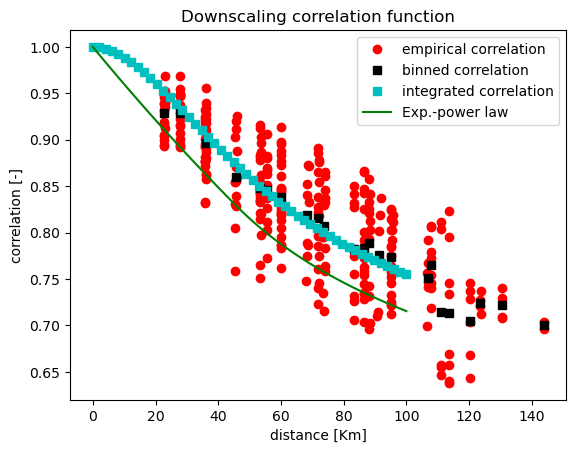

In [21]:
use_ave = True
xx = np.linspace(0.0, 100)

parnames = ['eps_d', 'alp_d'] if acf == 'mar' else ['d0_d', 'mu0_d']
corrL = int_corr(xx, (res[parnames[0]], res[parnames[1]]), acf, L1)

fig = plt.figure()
plt.plot(rcorr['vdist'], rcorr['vcorr'], 'or', label='empirical correlation')

if use_ave is True:
    res_ave = bin_ave_corr(rcorr['vdist'], rcorr['vcorr'], toll = 0.3, plot=plot)
    dd = res_ave['vdist_ave']
    cc = res_ave['vcorr_ave']
    plt.plot(dd, cc, 'sk', label='binned correlation')

plt.plot(xx, corrL, 'sc', label='integrated correlation')
if acf=='str':
    plt.plot(xx, str_exp_fun(xx, res[parnames[0]],
                res[parnames[1]]), 'r', label='Stretched exp.')
else:
    plt.plot(xx, epl_fun(xx, res[parnames[0]],
                res[parnames[1]]), 'g', label='Exp.-power law')
    
plt.xlabel('distance [Km]')
plt.ylabel('correlation [-]')
# plt.ylim([0.4, 1])
# plt.xlim([0.0, max(100, np.max(rcorr['vdist']))+10])
plt.legend()
plt.title('Downscaling correlation function')

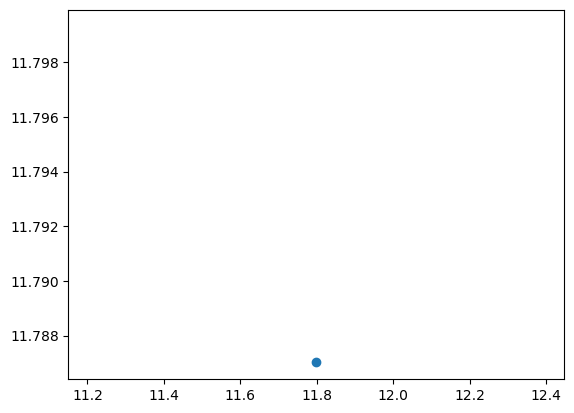

In [22]:
plt.plot(res['CYs'], res['CYd'], 'bo')
plt.plot(res['CYs'], res['CYs'], 'r.')

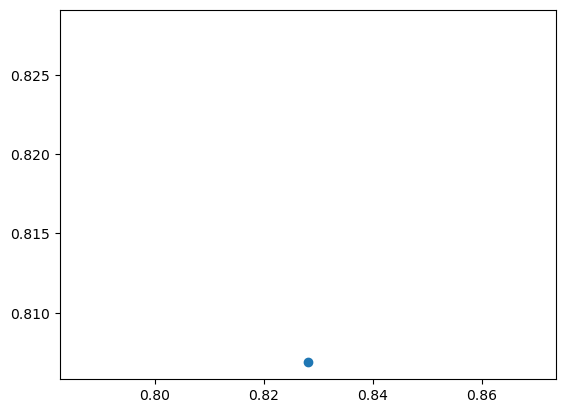

In [23]:
plt.plot(res['WYs'], res['WYd'], 'bo')
plt.plot(res['WYs'], res['WYs'], 'r.')

In [24]:
f = h5py.File(inputfile, "r")
tmpalat = f['lat'][:]
tmpalon = f['lon'][:]
lon2d, lat2d = np.meshgrid(tmpalon, tmpalat)

lon2d_input, lat2d_input = np.meshgrid(lons, lats)

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


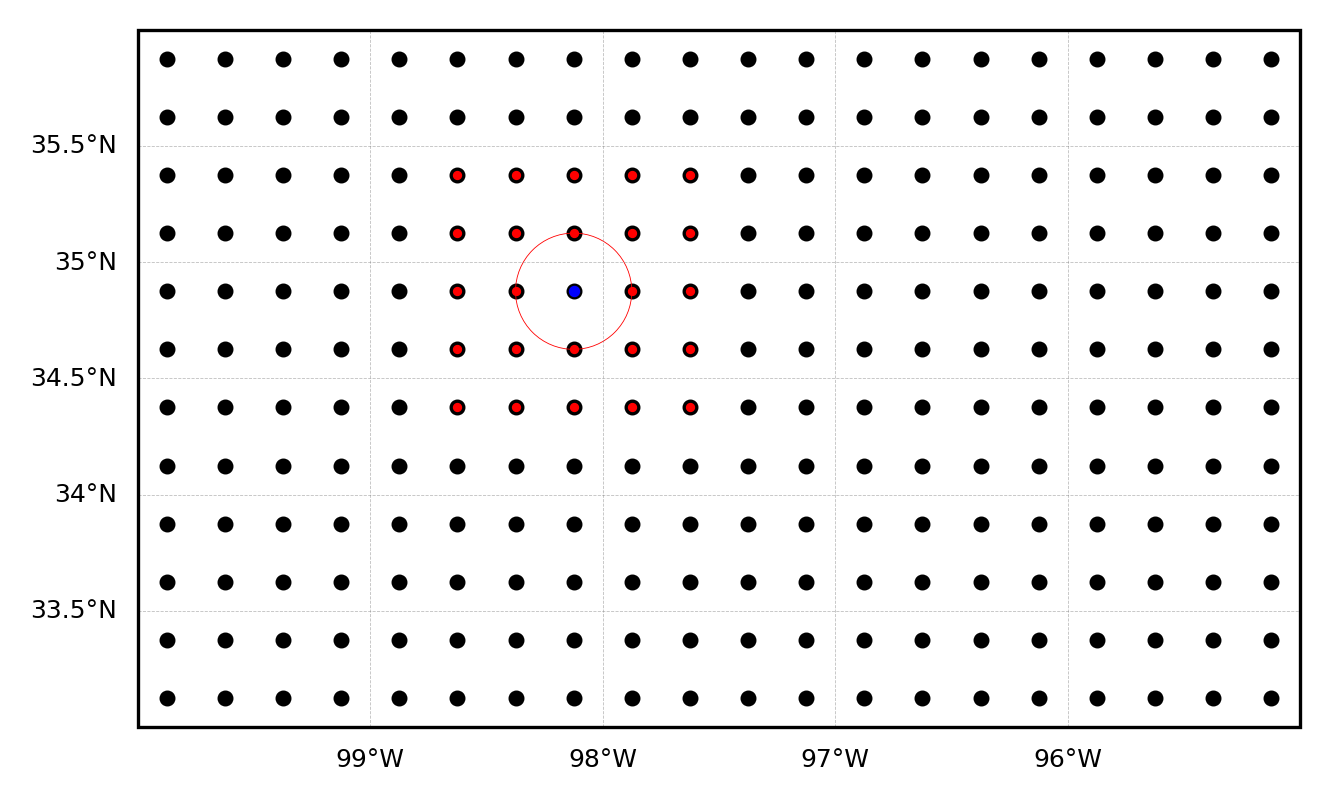

In [25]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,1)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-100, -95, 33, 36], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')

ax1.scatter(lon2d, lat2d, s=8, color='k')

# ax1.scatter(lons, lats, s=1.5, color='r')
ax1.scatter(lon2d_input, lat2d_input, s=1.5, color='r')

ax1.scatter(res['clon'], res['clat'], s=3, color='b')

circle = plt.Circle((res['clon'], res['clat']), dx, color='r', linewidth=0.2, fill=False)
ax1.add_artist(circle)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}